This notebook contains an implementation of the BB84 quantum key distribution (QKD) protocol as outlined in the classic quantum cryptography paper [http://dx.doi.org/10.1016/j.tcs.2014.05.025](http://dx.doi.org/10.1016/j.tcs.2014.05.025).

In [9]:
from random import randint,sample
def get_random_bitstring(sz):
    return [randint(0,1) for i in range(sz)]

In [10]:
from qiskit import (QuantumCircuit, execute, Aer)

In [11]:
default_backend = Aer.get_backend('qasm_simulator')

Define a couple of functions to encode and decode a qubit using the specified measurement basis. In the BB84 protocol, two bases are used. We choose to use $|0\rangle,|1\rangle$ (X-basis) and $|+\rangle,|-\rangle$ (Z-basis).

In [12]:
X_BASIS = 0
Z_BASIS = 1

In [13]:
def encode_key_bit(qbit, tx_bit, tx_base):
    '''
    Append encoding of the specified classical bit 'tx_bit' into the specified
    base 'tx_base' to the quantum circuit
    '''
    
    # flip the quantum 0 to quantum 1 if we received a '1' bit; otherwise leave 
    # it as a quantum 0.
    if tx_bit:
        qbit.x(0)
    
    # if we're transmitting using the x-basis, then leave it in the x-basis;
    # otherwise flip the qubit into the z-basis    
    if tx_base == Z_BASIS:
        qbit.h(0)            
        
    return qbit

In [14]:
def decode_key_bit(qbit, rx_base):
    '''
    Append measurement of the specified qubit 'qbit' in the specified base 'rx_base'
    to the quantum circuit
    '''

    # flip the qubit if we're measureing in the Z_BASIS so if the qubit
    # is originally in the X_BASIS, it will not be in superposition. Then
    # go ahead and measure it.
    if rx_base == Z_BASIS:
        qbit.h(0)    
    qbit.measure([0],[0])
    return qbit

Test out quantum encode/decode functions by plugging in a datum value and some tx/rx bases and verify that the full circuit looks as expected for the specified configuration (the barrier indicates the separation between the tx and rx portions of the full quantum circuit).

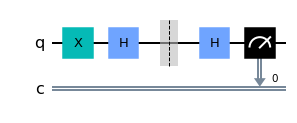

In [15]:
datum = 1
tx_base = 1
rx_base = 1

test_qc = QuantumCircuit(1,1)
test_qc = encode_key_bit(test_qc,datum,tx_base)
test_qc.barrier(0)
test_qc = decode_key_bit(test_qc,rx_base)

test_qc.draw('mpl')

Choose the pre-cull key bit length, create a secret key, and select random measurement bases for both Alice and Bob. We'll use the following bit + base coding scheme:

| Alice's secret bit from `random_tx_bits` | Corresponding bit in `random_tx_bases` | Encoding basis | Qubit state sent |
|:----------------:|:--------------------------:|:--------------------------:|:---------------:|
| 0 | 0 | $$|0\rangle,|1\rangle$$ |$$|0\rangle$$ |
| 0 | 1 | $$|+\rangle,|-\rangle$$ |$$|+\rangle$$ |
| 1 | 0 | $$|0\rangle,|1\rangle$$ |$$|1\rangle$$ |
| 1 | 1 | $$|+\rangle,|-\rangle$$ |$$|-\rangle$$ |

In [16]:
num_bits = 32

In [17]:
# set up Alice's transmission bits
random_tx_bits = get_random_bitstring(num_bits)
random_tx_bases = get_random_bitstring(num_bits)

In [18]:
# set up Bob's receiving bits
random_rx_bases = get_random_bitstring(num_bits)
decoded_rx_bits = []

Create a couple of classes to simulate the interface with shared quantum and classical channels.

In [19]:
class SharedChannel:
    
    def __init__(self):
        self.datum = None
        self.active = False
    
    def transmit_datum(self, datum):
        self.datum = datum
        self.active = True
        
    def receive_datum(self):
        return_datum = self.datum
        self.active = False
        self.datum = []
        return return_datum

In [20]:
class SharedQuantumChannel(SharedChannel):
    def __init__(self):
        super().__init__()

In [21]:
class SharedClassicalChannel(SharedChannel):
    def __init__(self):
        super().__init__()
        
    def transmit_data(self, datum):
        super().transmit_datum(datum)
        
    def receive_data(self):
        return super().receive_datum()

In [22]:
# create shared quantum and classical channels that Alice and Bob will
# use to communicate to each other
sqc = SharedQuantumChannel()
scc = SharedClassicalChannel()

Smoke test

In [23]:
scc.transmit_datum('1')
print(scc.receive_datum())

1


<b>Run the BB84 QKD protocol.</b> Alice has a secret encryption key she wants to share with Bob, without a potential eavesdropper, Eve, also getting a hold of the key. Eve can intercept information on both the quantum and classical channels (but is not allowed to actively delete or alter information on the classical channel). In a nutshell, Alice can share her key with Bob and know that Eve didn't intercept it on the quantum channel with the following protocol:

1. Alice encodes each qubit onto the shared quantum channel one-by-one, using a randomly selected basis, and Bob decodes them, also using a randomly selected basis for each measurement. 

2. Bob then sends Alice the list of bases he used for the decoding on the classical channel, and Alice compares them to the ones she used to encode the qubits. 

3. Alice uses the classical channel to inform Bob which ones he guessed right, and then both Alice & Bob throw away the qubits that were decoded using the wrong base.

4. Bob selects a subset of what's left and sends them back to Alice on the classical channel, along with their associated indices.

5. Alice checks Bob's results with the bits of her own secret key. If they all match, then Alice is assured that there was no eavesdropper on the quantum channel.

6. Alice and Bob discard the check bits, and now share the secret key.

In [24]:
# Clear decoded bits list and transmit the qbits one by one until the 
# receiver has measured every one    

decoded_rx_bits = []
for i in range(num_bits):
    
    # create a qubit, encode it, transmit it, receive it, 
    # and decode it
    qbit = QuantumCircuit(1,1)
    tx_qbit = encode_key_bit(qbit, random_tx_bits[i], random_tx_bases[i])
    sqc.transmit_datum(tx_qbit)
    rx_qbit = sqc.receive_datum()
    full_circuit = decode_key_bit(rx_qbit, random_rx_bases[i])

    job = execute(full_circuit, backend=default_backend, shots=1)
    results = job.result()
    counts = results.get_counts()    
    decoded_rx_bits.append(int(max(counts, key=counts.get)))
    
# decoder reports rx bases to transmitter
scc.transmit_data(random_rx_bases)
rx_bases_used = scc.receive_data()

# sender determines which random rx bases were right
assert(len(rx_bases_used) == len(random_tx_bits))
rx_base_hits = [rx_bases_used[i] == random_tx_bases[i] for i in range(len(random_tx_bits))]

# sender notifies receiver of key hits
scc.transmit_data(rx_base_hits)
rcvd_rx_base_hits = scc.receive_data()

# sender and receiver drop non-hit key bits
sender_key_candidate   = [j for i,j in enumerate(random_tx_bits) if rx_base_hits[i]]
receiver_key_candidate = [j for i,j in enumerate(decoded_rx_bits) if rcvd_rx_base_hits[i]]
assert(sender_key_candidate == receiver_key_candidate)

# the receiver chooses some verification bits (1/4th of the decoded key bits)
num_verify_bits = len(receiver_key_candidate)//4
verify_bits_ix = sample(range(len(receiver_key_candidate)), num_verify_bits)
verify_bits = {i:receiver_key_candidate[i] for i in verify_bits_ix}

# the receiver shares verification bits with sender
scc.transmit_data(verify_bits)
chk_verify_bits = scc.receive_data()
assert(verify_bits == chk_verify_bits)

# verify the check bits
verified = all([verify_bits[i] == sender_key_candidate[i] for i in verify_bits.keys()])

# if the check bits check out, strip them out of the key and we're done
if verified:
    sender_key   = [j for i,j in enumerate(sender_key_candidate) if i not in chk_verify_bits.keys()]
    receiver_key = [j for i,j in enumerate(receiver_key_candidate) if i not in verify_bits.keys()]
    assert(sender_key == receiver_key)
    
print('skey: ' + str(sender_key))
print('rkey: ' + str(receiver_key))

skey: [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]
rkey: [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]
